### Import Library

In [1]:
from nltk.tokenize import RegexpTokenizer
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import gzip
from collections import defaultdict
import json

In [10]:
class Doc2QueryAugmenter:
    """
    This class is responsible for generating queries for a document.
    These queries can augment the document before indexing.

    MUST READ: https://huggingface.co/doc2query/msmarco-t5-base-v1

    OPTIONAL reading
        1. Document Expansion by Query Prediction (Nogueira et al.): https://arxiv.org/pdf/1904.08375.pdf
    """
    def __init__(self, doc2query_model_name: str = 'doc2query/msmarco-t5-base-v1') -> None:
        """
        Creates the T5 model object and the corresponding dense tokenizer.
        
        Args:
            doc2query_model_name: The name of the T5 model architecture used for generating queries
        """
        self.device = torch.device('cpu')  # Do not change this unless you know what you are doing
        if torch.backends.cuda.is_built():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_built():
            self.device = torch.device('mps')
        print(f"Using {self.device}")
        # TODO (HW3): Create the dense tokenizer and query generation model using HuggingFace transformers
        self.tokenizer = T5Tokenizer.from_pretrained(doc2query_model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(doc2query_model_name).to(self.device)

    def get_queries(self, document: str, n_queries: int = 5, prefix_prompt: str = '') -> list[str]:
        """
        Steps
            1. Use the dense tokenizer/encoder to create the dense document vector.
            2. Use the T5 model to generate the dense query vectors (you should have a list of vectors).
            3. Decode the query vector using the tokenizer/decode to get the appropriate queries.
            4. Return the queries.
         
            Ensure you take care of edge cases.
         
        OPTIONAL (DO NOT DO THIS before you finish the assignment):
            Neural models are best performing when batched to the GPU.
            Try writing a separate function which can deal with batches of documents.
        
        Args:
            document: The text from which queries are to be generated
            n_queries: The total number of queries to be generated
            prefix_prompt: An optional parameter that gets added before the text.
                Some models like flan-t5 are not fine-tuned to generate queries.
                So we need to add a prompt to instruct the model to generate queries.
                This string enables us to create a prefixed prompt to generate queries for the models.
                See the PDF for what you need to do for this part.
                Prompt-engineering: https://en.wikipedia.org/wiki/Prompt_engineering
        
        Returns:
            A list of query strings generated from the text
        """
        # Note: Feel free to change these values to experiment
        document_max_token_length = 400  # as used in OPTIONAL Reading 1
        top_p = 0.85

        # NOTE: See https://huggingface.co/doc2query/msmarco-t5-base-v1 for details

        # TODO (HW3): For the given model, generate a list of queries that might reasonably be issued to search
        #       for that document
        # NOTE: Do not forget edge cases
        queries = []
        if n_queries > 0:
            text = prefix_prompt + document
            input_ids = self.tokenizer.encode(text, max_length=document_max_token_length, truncation=True, return_tensors='pt').to(self.device)
            outputs = self.model.generate(
                input_ids=input_ids,
                do_sample=True,
                max_length=64,
                top_p=top_p,
                num_return_sequences=n_queries
            )
            for output in outputs:
                query = self.tokenizer.decode(output, skip_special_tokens=True)
                queries.append(query)
        return queries
    
    def get_batched_queries(self, documents: list[str], n_queries: int = 5, prefix_prompt: str = '') -> list[list[str]]:
        document_max_token_length = 400  # as used in OPTIONAL Reading 1
        top_p = 0.85

        texts = [prefix_prompt + document for document in documents]
        input_ids = self.tokenizer.batch_encode_plus(texts, max_length=document_max_token_length, truncation=True, padding=True, return_tensors='pt').to(self.device)
        outputs = self.model.generate(
            input_ids=input_ids['input_ids'],
            do_sample=True,
            max_length=64,
            top_p=top_p,
            num_return_sequences=n_queries
        )
        # print(outputs.shape)

        queries = []
        if len(outputs) > 1:
            queries = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)
            queries = [queries[i:i+n_queries] for i in range(0, len(queries), n_queries)]
        return queries

In [11]:
def read_dataset(dataset_path: str, max_docs: int = -1, batch_size: int = 1):
    """Read the dataset from the path with a maximum number of documents to read

    Args:
        dataset_path (str): dataset path
        max_docs (int, optional): maximum number of documents to read. Defaults to -1.

    Yields:
        dict: a document
    """
    open_func = lambda x: gzip.open(x, 'rb') if x.endswith('.gz') else open(x, 'r')
    with open_func(dataset_path) as f:
        if batch_size > 1:
            batch = defaultdict(list)
            cnt = 0
            for i, line in enumerate(f):
                if max_docs != -1 and i >= max_docs:
                    break
                doc = json.loads(line)
                for k, v in doc.items():
                    batch[k].append(v)
                cnt += 1
                if cnt == batch_size:
                    yield batch
                    batch.clear()
                    cnt = 0
            if cnt > 0:
                yield batch
        else:
            for i, line in enumerate(f):
                if max_docs != -1 and i >= max_docs:
                    break
                yield json.loads(line)

In [12]:
DATASET_PATH = "si650-project/wikipedia_200k_dataset.jsonl.gz"
max_docs = 6400
batch_size = 32
n_queries = 5
token_key = "text"
prefix_prompt = "Generate a query for the following text: "
queries = {}
d2q = Doc2QueryAugmenter()

Using cuda


In [13]:
from time import time
from tqdm import tqdm

t1 = time()
for doc in tqdm(read_dataset(DATASET_PATH, max_docs, batch_size), total=max_docs//batch_size):
    doc_id = doc["docid"]
    texts = doc[token_key]
    if batch_size > 1:        
        batch_queries = d2q.get_batched_queries(texts, n_queries, prefix_prompt=prefix_prompt)
        for id, doc_queries in zip(doc_id, batch_queries):
            queries[id] = doc_queries
    else:
        queries[doc_id] = d2q.get_queries(texts, n_queries, prefix_prompt=prefix_prompt)

100%|██████████| 200/200 [08:10<00:00,  2.45s/it]


In [16]:
with open("doc2query_6400.json", "w") as f:
    json.dump(queries, f, indent=4)

### Bi-Encoder

In [19]:
related_docids = []
related_docs = []
for doc in tqdm(read_dataset(DATASET_PATH, max_docs), total=max_docs):
    doc_id = int(doc['docid'])
    related_docids.append(doc_id)
    related_docs.append(doc['text'])

100%|██████████| 6400/6400 [00:00<00:00, 7174.26it/s]


In [184]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import util, SentenceTransformer

class BiEncode:
    def __init__(self, bi_encoder_name):
        self.device = torch.device('cuda')
        self.model = SentenceTransformer(bi_encoder_name).to(self.device)
    
    def cos_sim(self, doc, queries, num_query):
        doc_emb = self.model.encode(doc, batch_size=128, show_progress_bar=False, normalize_embeddings=True)
        query_emb = self.model.encode(queries, batch_size=128, show_progress_bar=False, normalize_embeddings=True)
        m, n = query_emb.shape
        query_emb = query_emb.reshape(-1, num_query, n)
        query_emb_var = query_emb.var(axis=-2).sum(-1)
        query_emb = query_emb.mean(axis=-2)
        f1 = (doc_emb * query_emb).sum(-1)
        r1 = ((doc_emb - query_emb)**2).sum(-1)
        r2 = (query_emb_var + 1e-6)
        # print(r1.shape, r2.shape)
        f2 =  r1 / r2 
        return f1, f2, query_emb_var

In [185]:
bi_encoder_name = 'sentence-transformers/msmarco-distilbert-dot-v5'
encoder = BiEncode(bi_encoder_name)
encoder.model.encode(["hello, world", "where is michigan"])

array([[ 0.01516773,  0.40458512,  0.33601803, ...,  0.13327399,
         0.08983023, -0.00220924],
       [-0.26795918,  0.40976176,  0.02094324, ...,  0.02651545,
        -0.0959981 ,  0.13918507]], dtype=float32)

In [186]:
encoder.cos_sim(["hello", "say"], ["hello, world", "where is michigan", "hello, world", "where is michigan"], 2)

(array([0.8624313 , 0.79494095], dtype=float32),
 array([1.5272725, 2.7671297], dtype=float32),
 array([0.10886682, 0.10886682], dtype=float32))

In [189]:
import numpy as np

results = []
results_var = []
results_diff = []
batch_size = 128
for doc in tqdm(read_dataset(DATASET_PATH, max_docs, batch_size), total=max_docs//batch_size):
    doc_id = doc["docid"]
    texts = doc[token_key]
    doc_queries = []
    for docid in doc_id:
        doc_queries.extend(queries.get(docid, []))
    emb_sim, emb_diff, emb_var = encoder.cos_sim(texts, doc_queries, n_queries)
    results.append(emb_sim)
    results_diff.append(emb_diff)    
    results_var.append(emb_var)

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


In [190]:
results = np.concatenate(results)
results_diff = np.concatenate(results_diff)
results_var = np.concatenate(results_var)

/tmp/ipykernel_2514447/1243817846.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results)


<AxesSubplot: ylabel='Density'>

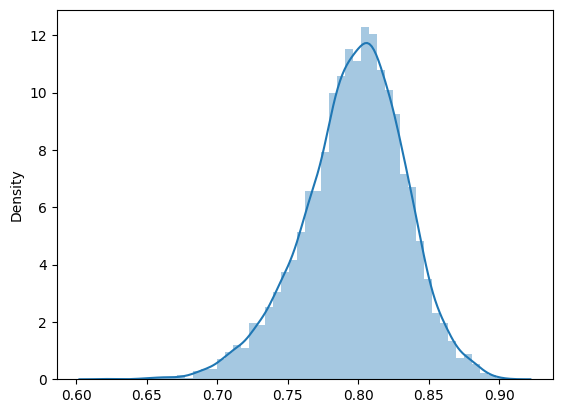

In [191]:
import seaborn as sns
sns.distplot(results)

/tmp/ipykernel_2514447/3761750761.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_var)


<AxesSubplot: ylabel='Density'>

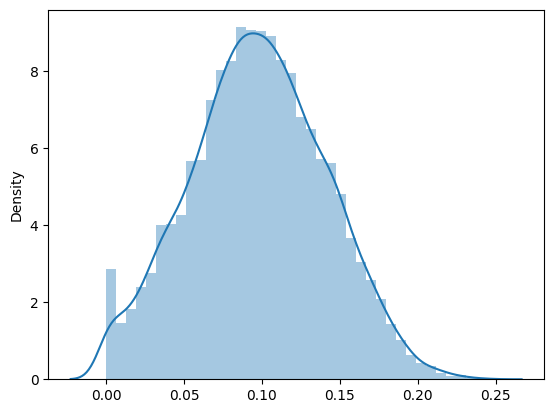

In [192]:
sns.distplot(results_var)

/tmp/ipykernel_2514447/2741701378.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_var + results)


<AxesSubplot: ylabel='Density'>

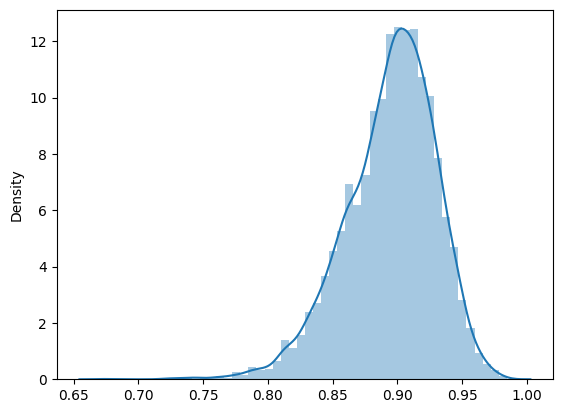

In [193]:
sns.distplot(results_var + results)

In [194]:
np.max(results_var + results)

0.9846246

In [195]:
np.min(results_var + results)

0.6726353

/tmp/ipykernel_2514447/583468324.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_diff)


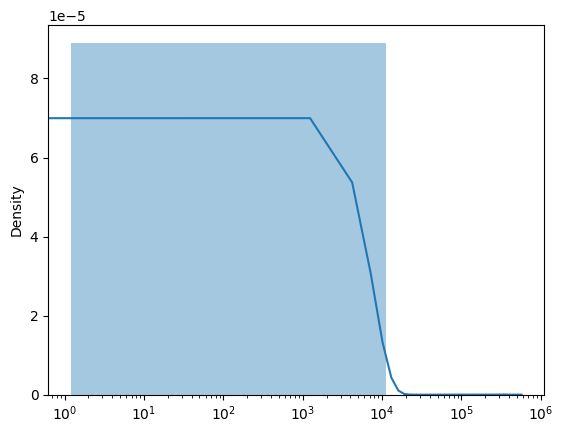

In [200]:
# results_diff.max()
import matplotlib.pyplot as plt
sns.distplot(results_diff)
plt.xscale('log')

#### Use the VectorRanker

In [231]:
class VectorRanker:
    def __init__(self, bi_encoder_model_name: str, encoded_docs,
                 row_to_docid: list[int], encode_var: None) -> None:
        """
        Initializes a VectorRanker object.

        Args:
            bi_encoder_model_name: The name of a huggingface model to use for initializing a 'SentenceTransformer'
            encoded_docs: A matrix where each row is an already-encoded document, encoded using the same encoded
                as specified with bi_encoded_model_name
            row_to_docid: A list that is a mapping from the row number to the document id that row corresponds to
                the embedding

        Using zip(encoded_docs, row_to_docid) should give you the mapping between the docid and the embedding.
        """
        # Use device='cpu' when doing model instantiation (for AG)
        # If you know what the parameter does, feel free to play around with it
        # TODO: Instantiate the bi-encoder model here
        self.device = torch.device('cpu')  # Do not change this unless you know what you are doing
        self.bi_encoder = SentenceTransformer(bi_encoder_model_name, device=self.device)
        # self.doc_to_encoded_doc = dict(zip(row_to_docid, encoded_docs))
        self.encoded_docs = encoded_docs
        self.row_to_docid = row_to_docid
        self.encode_var = encode_var if encode_var is not None else 0

    def query(self, query: str) -> list[tuple[int, float]]:
        """
        Encodes the query and then scores the relevance of the query with all the documents.

        Args:
            query: The query in its original form (no stopword filtering/tokenization)

        Returns:
            A sorted list of tuples containing the document id and its relevance to the query,
            with most relevant documents first
        """
        # NOTE: Do not forget to handle edge cases
        doc_id_score = []
        if len(query) != 0 and len(self.row_to_docid) != 0:
            # TODO: Encode the query using the bi-encoder
            encoded_query = self.bi_encoder.encode(query, device=self.device, normalize_embeddings=True)
            # TODO: Score the similarity of the query vector and document vectors for relevance
            # Calculate the dot products between the query embedding and all document embeddings
            similarity_scores = np.sum(encoded_query * self.encoded_docs, axis=1) + self.encode_var
            # TODO: Generate the ordered list of (document id, score) tuples
            doc_id_score = list(zip(self.row_to_docid, similarity_scores))
            # TODO: Sort the list so most relevant are first
            doc_id_score.sort(key=lambda x: (-x[1], x[0]))
        return doc_id_score

In [208]:
dev_ids = []
dev_encoded_docs = []

for docid, q in tqdm(queries.items()):
    dev_ids.append(docid)
    query_emb = encoder.model.encode(q).mean(0)
    dev_encoded_docs.append(query_emb)

dev_encoded_docs = np.array(dev_encoded_docs)

100%|██████████| 6400/6400 [00:39<00:00, 162.16it/s]


In [233]:
vec_ranker = VectorRanker(bi_encoder_name, dev_encoded_docs, dev_ids, results_var)

#### Relevance

In [234]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def map_score(search_result_relevances: list[int], cut_off=10) -> float:
    """
    Calculates the mean average precision score given a list of labeled search results, where
    each item in the list corresponds to a document that was retrieved and is rated as 0 or 1
    for whether it was relevant.

    Args:
        search_results: A list of 0/1 values for whether each search result returned by your 
                        ranking function is relevant
        cut_off: The search result rank to stop calculating MAP. The default cut-off is 10;
                 calculate MAP@10 to score your ranking function.

    Returns:
        The MAP score
    """
    # TODO: Implement MAP
    all_rel_doc = np.sum([1 if rel > 0 else 0 for rel in search_result_relevances])
    correct_pos = [pos for pos in range(cut_off) if search_result_relevances[pos] > 0]
    precision_k = [(i + 1) / (pos + 1) for i, pos in enumerate(correct_pos)]
    return np.sum(precision_k) / all_rel_doc if len(precision_k) > 0 else 0


def ndcg_score(search_result_relevances: list[float], 
               ideal_relevance_score_ordering: list[float], cut_off=10):
    """
    Calculates the normalized discounted cumulative gain (NDCG) given a lists of relevance scores.
    Relevance scores can be ints or floats, depending on how the data was labeled for relevance.

    Args:
        search_result_relevances: 
            A list of relevance scores for the results returned by your ranking function in the
            order in which they were returned. These are the human-derived document relevance scores,
            *not* the model generated scores.
            
        ideal_relevance_score_ordering: The list of relevance scores for results for a query, sorted by relevance score in descending order.
            Use this list to calculate IDCG (Ideal DCG).

        cut_off: The default cut-off is 10.

    Returns:
        The NDCG score
    """
    # TODO: Implement NDCG
    actual_len = min(len(search_result_relevances), cut_off)
    dcg = search_result_relevances[0] + np.sum([gain / np.log2(pos + 2) for pos, gain in enumerate(search_result_relevances[1:actual_len])]) if actual_len != 0 else 0
    ideal_len = min(len(ideal_relevance_score_ordering), cut_off)
    idcg = ideal_relevance_score_ordering[0] +np.sum([gain / np.log2(pos + 2) for pos, gain in enumerate(ideal_relevance_score_ordering[1:ideal_len])]) if ideal_len != 0 else 0
    return dcg / idcg if idcg > 0 else 0


def run_relevance_tests(relevance_data_filename: str, ranker, dev_ids: None) -> dict[str, float]:
    # TODO: Implement running relevance test for the search system for multiple queries.
    """
    Measures the performance of the IR system using metrics, such as MAP and NDCG.
    
    Args:
        relevance_data_filename [str]: The filename containing the relevance data to be loaded

        ranker: A ranker configured with a particular scoring function to search through the document collection.
                This is probably either a Ranker or a L2RRanker object, but something that has a query() method

    Returns:
        A dictionary containing both MAP and NDCG scores
    """
    # TODO: Load the relevance dataset.
    relevance_df = pd.read_csv(relevance_data_filename)
    if dev_ids is not None:
        relevance_df = relevance_df[relevance_df['docid'].isin(dev_ids)]
    # TODO. Run all the dataset's queries using the provided ranker object.
    map_scores = []
    ndcg_scores = []

    # Label the outputs from the algorithm using the relevance dataset.
    # NOTE: Our relevance score has five levels (1-5). Use multi-level scores (1-5) when calculating NDCG.
    # When calculating MAP, treat 1-3 as non-relevant (0) and 4-5 as relevant (1) because MAP uses binary scores.
    # For example, if we have a list of labeled outputs like [4, 5, 3, 4, 1, 2, 1],
    # convert this into [1, 1, 0, 1, 0, 0, 0] when you calculate the MAP score.
    for query, relevance_doc in tqdm(relevance_df.groupby('query')):
        doc_to_rel = {}
        for _, row in relevance_doc.iterrows():
            doc_to_rel[row['docid']] = row['rel']
        result_doc = ranker.query(query)
        if isinstance(result_doc[0], dict):
            result_doc = [result.get('docid') for result in result_doc]
        else:
            result_doc = [result[0] for result in result_doc]
        result_rel = [doc_to_rel.get(result, 1) for result in result_doc]
        ideal_rel = sorted(doc_to_rel.values(), reverse=True)
        map_result_rel = list(map(lambda x: 1 if x > 3 else 0, result_rel))
        map_scores.append(map_score(map_result_rel))
        ndcg_scores.append(ndcg_score(result_rel, ideal_rel))
    # TODO: Compute the average MAP and NDCG across all queries and return the scores. 
    map_avg_score = np.mean(map_scores)
    ndcg_avg_score = np.mean(ndcg_scores)
    # 3: Return the scores.
    return {'map': map_avg_score, 'ndcg': ndcg_avg_score, 'map_scores': map_scores, 'ndcg_scores': ndcg_scores}


In [235]:
train_filename = "si650-project/hw2_relevance.train.csv"
p1_pipeline_info = run_relevance_tests(train_filename, vec_ranker, set(dev_ids))
p1_pipeline_info['map'], p1_pipeline_info['ndcg']

100%|██████████| 124/124 [00:04<00:00, 26.82it/s]


(0.058232511962350665, 0.8390042240888961)

In [236]:
test_filename = "si650-project/hw2_relevance.test.csv"
p2_pipeline_info = run_relevance_tests(test_filename, vec_ranker, set(dev_ids))
p2_pipeline_info['map'], p2_pipeline_info['ndcg']

100%|██████████| 34/34 [00:01<00:00, 26.36it/s]


(0.049338235294117655, 0.7987914305150313)

In [237]:
dev_filename = "si650-project/hw2_relevance.dev.csv"
p3_pipeline_info = run_relevance_tests(dev_filename, vec_ranker, set(dev_ids))
p3_pipeline_info['map'], p3_pipeline_info['ndcg']

100%|██████████| 18/18 [00:00<00:00, 28.35it/s]


(0.05555555555555555, 0.7068466247385624)

In [241]:
a = np.array(p1_pipeline_info['map_scores']) 
a = a[(a> 0)]
a.mean()

0.24069438277771607